In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import src
from src.reload import deep_reload

In [35]:
np.exp(np.linspace(0, 1, 5)) - 1

array([0.        , 0.28402542, 0.64872127, 1.11700002, 1.71828183])

In [36]:
deep_reload(src)

n = 100
k = 2

rng = np.random.default_rng(26893751)

kwargs = {
    'rng': rng,
    'label': 'place',
    'x': lambda n: rng.uniform(0, 1e6, size = (n, )),
    'y': lambda n: rng.uniform(0, 1e6, size = (n, )),
    'node_functions': {
        # 'population': lambda n: 10 ** rng.uniform(3, 7),
        'population': lambda n: 1e3,
        'size': lambda n: rng.uniform(1, 10),
        'capacity': lambda n: np.linspace(0, 1, 5) * rng.uniform(3, 7),
        'delay': lambda n: (np.exp(np.linspace(0, 1, 5)) - 1) * rng.uniform(60, 600) * 10,
    },
    'edge_functions': {
        'speed': lambda e: rng.uniform(65, 65) * 1609 / 3600,
        'time': lambda e: e['distance'] / e['speed'],
    },
    'nx': {
        'directed': True,
    },
}

graph = src.rng.random_connected_graph(n, k, **kwargs)

kw = {
    'fields': ['time', 'distance'],
}

apg = src.rng.all_pairs_graph(graph, **kw)

kw = {
    'fields': ['time', 'distance'],
    'conditions': [lambda e: e['distance'] <= 300e3],
}

apg_300 = src.rng.all_pairs_graph(graph, **kw)

In [37]:
deep_reload(src)

n = 15

rng = np.random.default_rng(26589763514)

places = rng.choice(graph.nodes, replace = False, size = n)
stations = list(set(graph.nodes) - set(places))

# for place in places:

#     apg._node[place]['size'] = 0

values, bins = pkl.load(open('histogram.pkl', 'rb'))
friction = src.gravity.Friction(values, bins * 1e3)

kw = {
    # 'friction': friction,
}

sg = src.graph.subgraph(apg, places)

gravity = src.gravity.Gravity(sg, **kw)

In [90]:
deep_reload(src)

kw = {
    'edge_cost': 'distance',
    'edge_bounds': (150e3, 300e3),
    'node_class': src.optimization.Linearized_Node,
    # 'node_class': src.optimization.Bilevel_Capacitated_Node,
    # 'link_class': src.optimization.Link,
    'objective': 'time',
    'verbose': True,
    'infeasible_penalty': 0,
    'scale': 1,
}

demand = gravity.volumes(1e2)
# m = 10
# demand = {place: {place: m for place in places} for place in places}

opt = src.optimization.Optimization(apg, demand, **kw)

solver_kwargs = {'_name': 'cbc'}
# solver_kwargs = {'_name': 'appsi_highs'}
# solver_kwargs = {'_name': 'cplex_direct'}

opt.solve(**solver_kwargs, tee = False)

Elements Built: 0.05466413497924805
Parameters Built: 0.002343893051147461
Variables Built: 0.07938385009765625
Constraints Built: 0.1300358772277832
Objective Built: 0.24206948280334473
Problem Solved: 0.22529268264770508
Results Collected: 0.007931709289550781


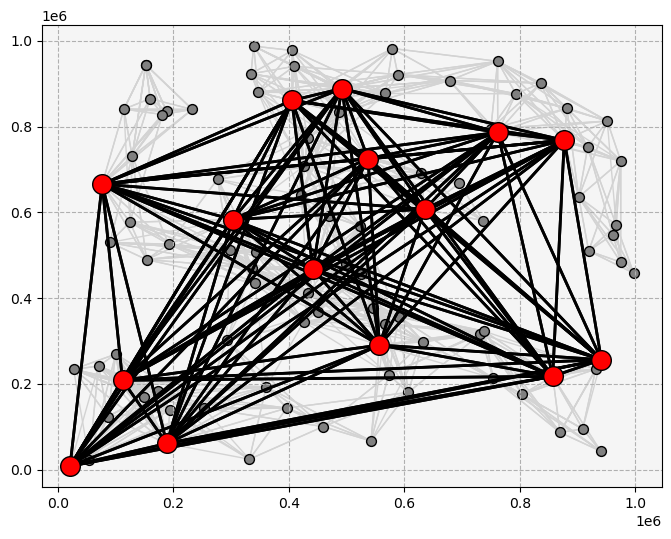

In [91]:
deep_reload(src)

fg = src.optimization.flow_graph(apg, opt.volumes, epsilon = .0000001)
data = {k.split(':')[0]: v[0] / 3600 \
        for k, v in opt.results.items() if 'delay' in k}

# data = opt.traffic

for source, node in fg._node.items():

    node['plot'] = data.get(source, np.nan)

src.figures.flow_plot(apg_300, fg, data, list(demand.keys()), epsilon = .000001)

In [87]:
opt.model.infeasible_penalty.pprint()

infeasible_penalty : Size=1, Index=None, Domain=Any, Default=None, Mutable=True
    Key  : Value
    None :  0.65
